# Worksheet 17

Name: Guanxi Li
UID: U14373976

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

1. Data Representation
Convert the user interactions into a matrix where rows represent users and columns represent movies. Entries in the matrix are: 1 if the user liked the movie, -1 or 0 (depending on the model) if the user disliked the movie. Unknown or NA if the user has not rated the movie.
2. Similarity Metrics
Use similarity metrics such as cosine similarity, Pearson correlation to measure the similarity between users or items.
3. Model
Train the chosen model on the user-item interactions matrix: the model will learn the latent factors that best represent the user-item interactions.
4. Generate Recommendations
Use the trained model to generate recommendations for users. The model will predict the user's preference for items they have not interacted with, and recommend the items with the highest predicted preference.
5. Evaluation
Evaluate the model's performance using metrics such as precision, recall, F1-score, and AUC-ROC.

b) Describe 3 challenges of building a recommender system

1. Data Sparsity: This sparsity makes it difficult to find similarities between users or items and to make accurate recommendations. It can also lead to issues like cold start, where new users or items have insufficient interactions for meaningful recommendations.
2. Scalability:The computational complexity of finding similar users or items in collaborative filtering increases with the size of the user-item matrix. Processing time and memory usage can become prohibitively high for very large datasets.
3. Cold Start: Cold start refers to the problem of making recommendations for new users or items that have little to no interaction history. Collaborative filtering methods rely on user-item interactions to make recommendations, so new users or items may not have enough data for accurate predictions.


c) Why is SVD not an option for collaborative filtering?

Singular Value Decomposition (SVD) is not typically used directly for collaborative filtering due to a few key limitations:

1. Sparsity Handling: SVD requires a fully populated matrix, but user-item matrices in collaborative filtering are usually very sparse, as most users have not rated most items.
2. Computational Intensity: SVD is computationally expensive, which poses challenges for large datasets.
3. Dynamic Data: SVD does not naturally accommodate the dynamic addition of new users or items without recomputation.

d) Use the code below to train a recommender system on a dataset of amazon movies

C:\Users\23798\AppData\Local\Temp\ipykernel_4656\3999928716.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_processed['Score'].fillna(Y_train.mean(), inplace=True)
C:\Users\23798\AppData\Local\Temp\ipykernel_4656\3999928716.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.097733333333333' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  X_test_processed['Score'].fillna(Y_train.mean(), i

Kaggle RMSE =  1.428861492989603


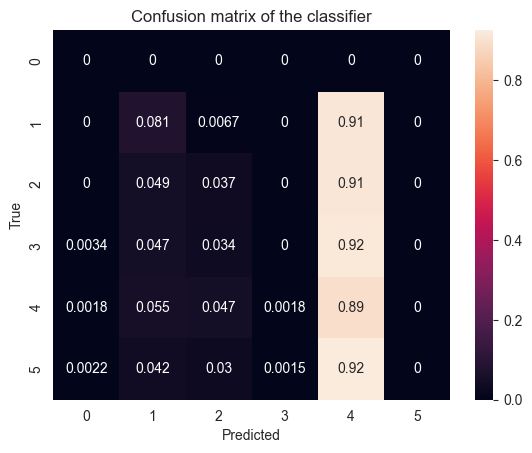

In [19]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
# param_grid = ParamGridBuilder().addGrid(
        # als.rank, [10, 50]).addGrid(
        # als.regParam, [.1]).addGrid(
        # # als.maxIter, [10]).build()
# evaluator = RegressionEvaluator(
        # metricName="rmse",
        # labelCol="Score",
        # # predictionCol="prediction")
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
# cv_fit = cv.fit(df)
# rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)

rec_pd = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()
X_test_processed = X_test_processed.merge(rec_pd, on=['UserId_fact', 'ProductId_fact'], how='left')
X_test_processed.rename(columns={'prediction': 'Score'}, inplace=True)
X_test_processed['Score'].fillna(Y_train.mean(), inplace=True)



print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

cm = confusion_matrix(Y_test, X_test_processed['Score'].round(), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()